In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [91]:
# hidden features provided by Markus Petterson and merged with other variables like country, etc.
X_train = pd.read_csv(f'./vlad_features/oot_span/E/merged_train.csv')
X_val = pd.read_csv(f'./vlad_features/oot_span/E/merged_val.csv')
X_test = pd.read_csv(f'./vlad_features/oot_span/E/merged_test.csv')


X = pd.concat([X_train, X_val, X_test], axis = 0)
X = pd.get_dummies(X, columns = ['country'])
# leave only variables of interest
X = X.drop(columns = ['Unnamed: 0', 'y', 'w',
                      'year', 'lat', 'lon', 'GID_1', 'GID_2'])

train_size, val_size, test_size = X_train.shape[0], X_val.shape[0], X_test.shape[0]

assert train_size + val_size + test_size == X.shape[0]

X_train = X[:train_size]
y_train = X_train.pop('iwi')

X_val = X[train_size : train_size + val_size]
y_val = X_val.pop('iwi')

X_test = X[train_size + val_size: ]
y_test = X_test.pop('iwi')

# Ada Boost

In [4]:
# Define hyperparameter options
n_estimators_options = [50, 100, 200]
learning_rate_options = [0.01, 0.1, 0.5]
max_depth_options = [3, 5, 7]

best_model = None
lowest_mse = np.inf
best_params = {}

In [5]:
%%time

# perform search for the best hyperparameters that maximize performance on the validation set
for n_estimators in n_estimators_options:
    for learning_rate in learning_rate_options:
        for max_depth in max_depth_options:
            # Define the base estimator
            base_estimator = DecisionTreeRegressor(max_depth=max_depth)

            # Initialize AdaBoost with the current set of hyperparameters
            model = AdaBoostRegressor(
                base_estimator=base_estimator,
                n_estimators=n_estimators,
                learning_rate=learning_rate
            )

            # Fit the model on the training data
            model.fit(X_train, y_train)

            # Predict on the validation set
            y_pred = model.predict(X_val)

            # Calculate the MSE on the validation set
            mse = mean_squared_error(y_val, y_pred)

            # Check if this model is better; if so, update best_model and lowest_mse
            if mse < lowest_mse:
                lowest_mse = mse
                best_model = model
                best_params = {
                    'n_estimators': n_estimators,
                    'learning_rate': learning_rate,
                    'max_depth': max_depth
                }

/Users/darkhero/micromamba/envs/cs109a/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/darkhero/micromamba/envs/cs109a/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/darkhero/micromamba/envs/cs109a/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/darkhero/micromamba/envs/cs109a/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/darkhero/micromamba/envs/cs109a/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` wa

CPU times: user 19min 38s, sys: 12.5 s, total: 19min 50s
Wall time: 20min 4s


In [6]:
print("Best Parameters:", best_params)
print("Lowest MSE on Validation Set:", lowest_mse)

Best Parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 7}
Lowest MSE on Validation Set: 50.973573363177096


In [14]:
base_estimator = DecisionTreeRegressor(max_depth=best_params['max_depth'])

best_model = AdaBoostRegressor(
    base_estimator=base_estimator,
    n_estimators=best_params['n_estimators'],
    learning_rate=best_params['learning_rate']
)

best_model.fit(pd.concat([X_train, X_val], axis = 0), pd.concat([y_train, y_val], axis = 0))

/Users/darkhero/micromamba/envs/cs109a/lib/python3.9/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostRegressor(base_estimator=DecisionTreeRegressor(max_depth=7),
                  learning_rate=0.01, n_estimators=200)

In [15]:
y_pred = best_model.predict(X_test)
print(f"OOT R2_score = {r2_score(y_test, y_pred)}\n")

print('correlation table:')
pd.DataFrame(data = {'y_true' : y_test, 'y_pred' : y_pred}).corr()

OOT R2_score = 0.6927975405440863

correlation table:


,y_true,y_pred
y_true,1.000000,0.840915
y_pred,0.840915,1.000000


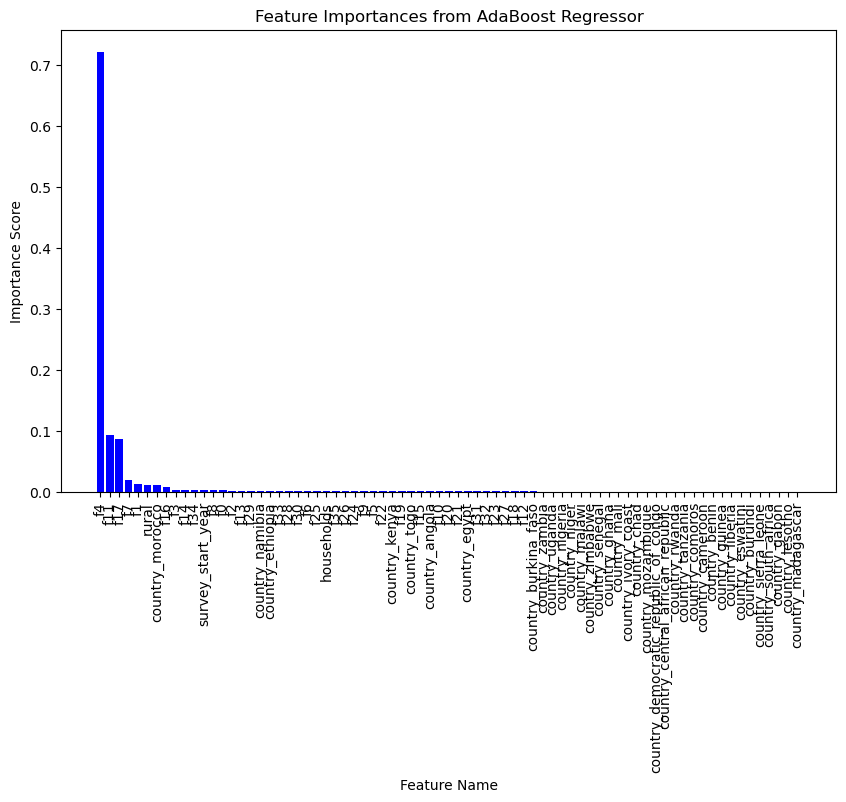

In [16]:
# Extract feature importances
importances = best_model.feature_importances_

# Sort feature importances in descending order and make a bar plot
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], color='b', align='center')
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Importance Score')
plt.title('Feature Importances from AdaBoost Regressor')
plt.show()

# Linear Models

In [50]:
def fit_linear(X_train, y_train, X_val, y_val, model_type = 'ridge'):
    try_alphas = np.logspace(-4, 4, 20)

    min_error = np.inf 
    for alpha in try_alphas:
        
        if model_type == 'ridge':
            model = Ridge(alpha=alpha)
        else:
            model = Lasso(alpha=alpha)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, y_pred)
        if mse < min_error:
            min_error = mse
            best_alpha = alpha

    print(f"Best alpha: {best_alpha}")    
    model = Ridge(alpha = best_alpha)
    model.fit(pd.concat([X_train, X_val], axis = 0), 
              pd.concat([y_train, y_val], axis = 0))
    
    return model

# Ridge

In [54]:
best_ridge = fit_linear(X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, 
                        model_type = 'ridge')

Best alpha: 545.5594781168514


In [55]:
best_ridge.fit(pd.concat([X_train, X_val], axis = 0), pd.concat([y_train, y_val], axis = 0))

y_pred = best_ridge.predict(X_test)
print(f"OOT R2_score = {r2_score(y_test, y_pred)}\n")

print('correlation table:')
pd.DataFrame(data = {'y_true' : y_test, 'y_pred' : y_pred}).corr()

OOT R2_score = 0.7142321227923447

correlation table:


,y_true,y_pred
y_true,1.00000,0.85027
y_pred,0.85027,1.00000


# Lasso (best performer in this notebook)

In [56]:
best_lasso = fit_linear(X_train = X_train, y_train = y_train, X_val = X_val, y_val = y_val, model_type = 'lasso')
best_lasso.fit(pd.concat([X_train, X_val], axis = 0), pd.concat([y_train, y_val], axis = 0))

/Users/darkhero/micromamba/envs/cs109a/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.549e+05, tolerance: 1.249e+03
  model = cd_fast.enet_coordinate_descent(
/Users/darkhero/micromamba/envs/cs109a/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.975e+05, tolerance: 1.249e+03
  model = cd_fast.enet_coordinate_descent(
/Users/darkhero/micromamba/envs/cs109a/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features

Best alpha: 0.012742749857031334


Ridge(alpha=0.012742749857031334)

In [57]:
y_pred = best_lasso.predict(X_test)
print(f"OOT R2_score = {r2_score(y_test, y_pred)}\n")

print('correlation table:')
pd.DataFrame(data = {'y_true' : y_test, 'y_pred' : y_pred}).corr()

OOT R2_score = 0.7246176950375345

correlation table:


,y_true,y_pred
y_true,1.000000,0.854428
y_pred,0.854428,1.000000


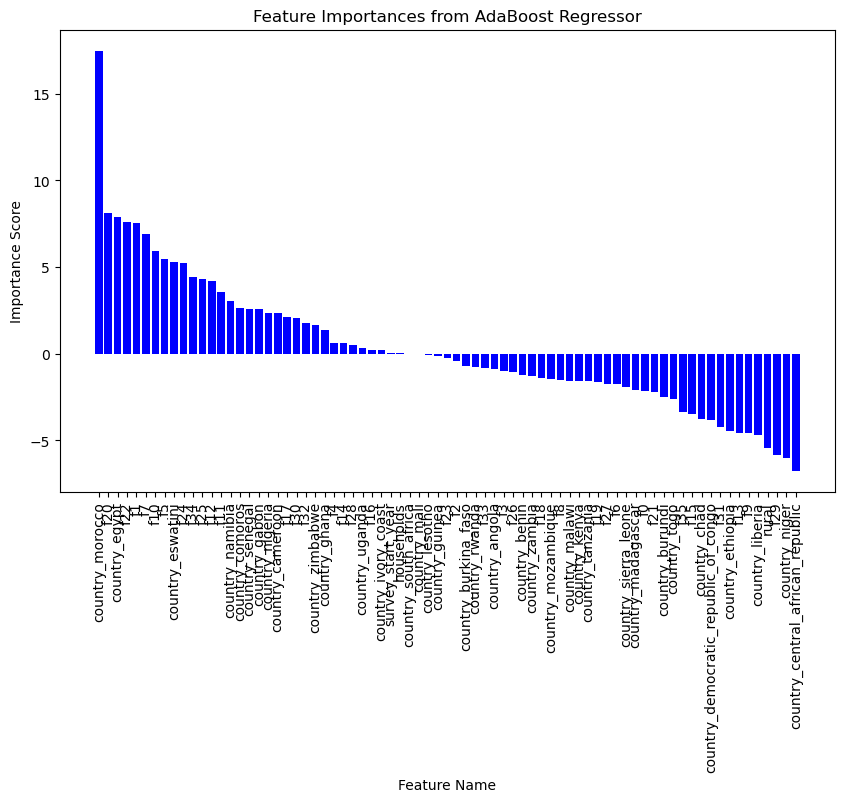

In [58]:
# Extract feature importances
importances = best_lasso.coef_

# Sort feature importances in descending order and make a bar plot
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices], color='b', align='center')
plt.xticks(range(X_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Importance Score')
plt.title('Feature coefficients from Lasso')
plt.show()

# Random Forrest Regressor

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)

# Fit the model
rf.fit(pd.concat([X_train, X_val], axis = 0), pd.concat([y_train, y_val], axis = 0))

RandomForestRegressor(random_state=42)

In [42]:
y_pred = rf.predict(X_test)
print(f"OOT R2_score = {r2_score(y_test, y_pred)}\n")

print('correlation table:')
pd.DataFrame(data = {'y_true' : y_test, 'y_pred' : y_pred}).corr()

OOT R2_score = 0.7000420782629214

correlation table:


,y_true,y_pred
y_true,1.000000,0.842776
y_pred,0.842776,1.000000
